# Datamining

In [1]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
#import pickle
#from yellowbrick import __version__ as yb_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [2]:
df_mood = pd.read_csv(r'data/dataset_mood_smartphone.csv', sep=',', index_col=0)
print('nr of entries: ', len(df_mood))
df_mood['time'] = df_mood['time'].astype('datetime64[ns]')

df_mood.head()

nr of entries:  376912


,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


(5641, 5643, 5643, 22965, 96578, 5239, 1798, 91288, 74276, 27125, 939, 813, 5642, 7650, 19145, 2846, 939, 2487, 255)


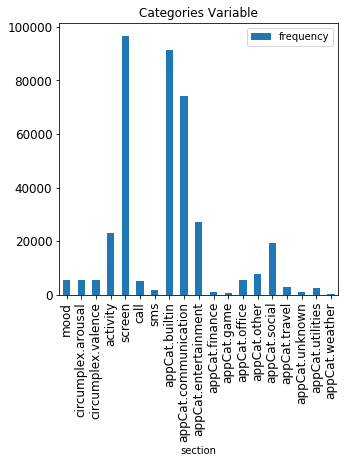

In [3]:
from collections import Counter

labels, values = zip(*Counter(df_mood['variable']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

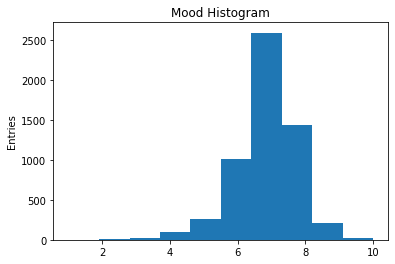

In [4]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='mood']

x = sub_mood['value']
plt.hist(x)
plt.gca().set(title='Mood Histogram', ylabel='Entries');

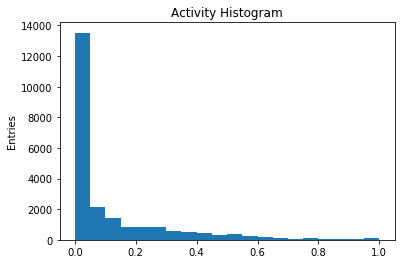

In [5]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='activity']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Activity Histogram', ylabel='Entries');

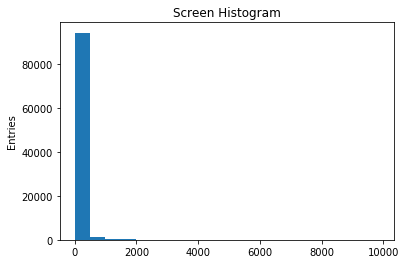

In [14]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='screen']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Screen Histogram', ylabel='Entries');

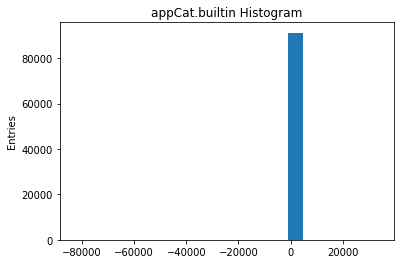

In [8]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='appCat.builtin']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.builtin Histogram', ylabel='Entries');

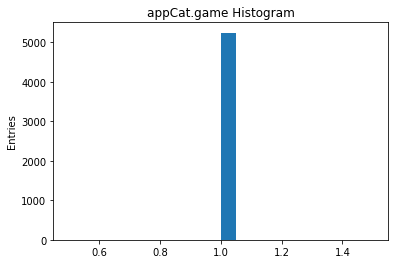

In [13]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='call']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.game Histogram', ylabel='Entries');

In [12]:
print('Max: ', df_mood[df_mood['variable']=='appCat.builtin'].max())

Max:  id                             AS14.33
time        2014-06-08 11:04:46.335000
variable                appCat.builtin
value                          33960.2
dtype: object


In [4]:
print('Min: ', df_mood['value'].min())
print('Max: ', df_mood['value'].max())


Min:  -82798.871
Max:  33960.246


## Aggregate Data

### step 1: Count days since inclusion
This is an important step to prepare the data for time window aggregation.

In [5]:
class Aggregation(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
    
    def setDF(self):
        self.df = df
        
    def getDF(self):
        return self.df
    
    def formatTimeSpan(self):
        """
        Translate time stamps to time in days ever since inclusion of said user
        
        Translate informational absent single observation columns 
        to meaningful frequencies. (For example: sms & calls columns)
        
        """
        cols = list(self.df.keys())
        cols.append('days')
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub = self.countTheDays(df_sub)
            for day in range(df_sub['days'].max()):
                df_day = df_sub[df_sub['days']==day]
                nr_calls = len(df_day[df_day['variable']=='call'])
                #print(nr_calls)
                if nr_calls != 0:
                    df_calls = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_calls', nr_calls, day])])
                    df_calls = df_calls.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    #print(df_calls)
                    
                    df_sub = pd.concat([df_sub, df_calls], axis=0)
                nr_sms = len(df_day[df_day['variable']=='sms'])
                if nr_sms != 0:
                    df_sms = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_sms', nr_sms, day])])
                    df_sms = df_sms.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    df_sub = pd.concat([df_sub, df_sms], axis=0)
                if day not in list(df_sub['days'].unique()):
                    #print(day)
                    s = pd.DataFrame([pd.Series([df_sub['id'].iloc[0],np.nan,'mood',np.nan, day], index=cols)])
                    df_sub = pd.concat([df_sub, s], axis=0, ignore_index=True)# df_sub.append(s, ignore_index=True)
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        
    def countTheDays(self, df_sub):
        initial_date = df_sub[self.timestamp].min()
        df_sub['days'] = pd.to_datetime(df_sub[self.timestamp]).sub(initial_date).dt.days
        return df_sub
    
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,time,variable,value,days
0,AS14.01,2014-02-26 13:00:00,mood,6.0,9
1,AS14.01,2014-02-26 15:00:00,mood,6.0,9
2,AS14.01,2014-02-26 18:00:00,mood,6.0,9
3,AS14.01,2014-02-26 21:00:00,mood,7.0,9
4,AS14.01,2014-02-27 09:00:00,mood,6.0,9


In [127]:
print(len(temp_df))
print(len(temp_df[((temp_df['variable']!='call') &(temp_df['variable']!='sms'))]))

379176
372139


## Aggregate History

### Step 1: Transform long to wide
### Step 2: Aggregate 

In [108]:
class Aggregation2(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
        
    def getFinalMood(self, row):
        #print(row['days'])
        next_day = int(row['days']) + 1
        
        subject = row['id']
        if next_day < len(self.df[self.df[self.key]==subject]):
            next_mood = self.df[((self.df[self.key]==subject)&(self.df['days']==next_day))]['mood'].iloc[0]
            # print(next_mood)
        else :
            next_mood = np.nan
        return next_mood
    
    def aggregate(self, window_size):
        # create sub df for each subject
        cols = list(self.df.keys())
        #print(cols)
        cols.append('final_mood') # add label
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub.rolling(5).agg({'activity':'mean', 'appCat.builtin':'mean', 'appCat.communication':'mean','appCat.entertainment':'mean', 
                           'appCat.other':'mean','appCat.social':'mean', 'appCat.travel':'mean', 'circumplex.arousal':'mean',  
                           'circumplex.valence':'mean',  'mood':'mean',  'screen':'mean',  'total_calls':'mean',  'total_sms':'mean'})
            df_sub['final_mood'] = df_sub['days'].copy()
            df_sub['final_mood'] = df_sub.apply(lambda x : self.getFinalMood(x), axis=1)
            df_sub['days'] = df_sub['days'].apply(lambda x : 'day '+ str(x-window_size+1)+ ' to ' + str(x+1))
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        return
    
    def getDF(self):
        return self.df

temp_df_unstack = temp_df.groupby(['id', 'days','variable'])['value'].median().unstack('variable')
temp_df_unstack = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen',
       'total_calls', 'total_sms']]
temp_df_unstack = temp_df_unstack.reset_index(level=1, drop=False)
temp_df_unstack = temp_df_unstack.reset_index()
temp_df_unstack.to_csv(r'data/prep_temporal_raw.csv', index = False, header=True)
agg = Aggregation2(temp_df_unstack, 'id', 'time', window=5)
agg.aggregate(5)
temp_df_2 = agg.getDF()
temp_df_2.head()

## Write preprocessed aggregated datasets
Two versions:
- With missing mood values or labels () (raw)
- Without missing mood values or labels
Note: we also ensure that the current mood was registered otherwise we cant compare to baseline

In [99]:
print('Nr entries with available label:', len(temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))]))
print('Nr of entries with missing label:', len(temp_df_2[((temp_df_2['final_mood'].isna()) | (temp_df_2['mood'].isna()))]))
temp_df_2.to_csv(r'data/prep_aggregated_raw.csv', index = False, header=True)
temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))].to_csv(r'data/prep_aggregated_noNan.csv', index = False, header=True)

1232


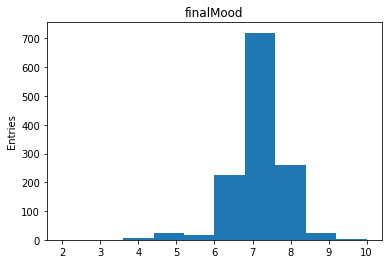

In [100]:
from collections import Counter

x = temp_df_2['final_mood']
plt.hist(x, bins=10)
plt.gca().set(title='finalMood', ylabel='Entries');

In [103]:
df_agg = pd.read_csv(r'data/prep_aggregated_noNan.csv', sep=',')
print('nr of entries: ', len(df_agg))
df_agg.head()

nr of entries:  1232


,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms,final_mood
0,AS14.01,day 5 to 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,0.5,6.0,NaN,1.0,2.0,7.0
1,AS14.01,day 27 to 32,0.008333,3.0410,27.6845,22.7870,13.6375,65.335,14.067,-0.5,0.0,6.0,31.748,NaN,NaN,7.0
2,AS14.01,day 28 to 33,0.144068,3.9040,24.6470,21.2360,10.1110,42.241,19.696,1.0,1.0,7.0,27.813,6.0,NaN,7.0
3,AS14.01,day 29 to 34,0.218487,4.0190,20.4580,46.6620,12.0540,40.275,NaN,0.0,1.0,7.0,17.975,3.0,1.0,6.0
4,AS14.01,day 30 to 35,0.055645,3.1085,19.8080,21.5865,9.0280,44.157,NaN,1.0,0.0,6.0,25.985,NaN,NaN,6.0


## missingness

In [104]:
import seaborn as sns

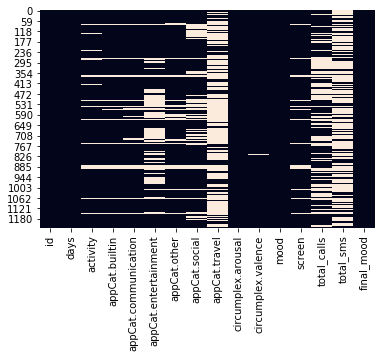

In [107]:
heatmap = sns.heatmap(df_agg.isnull(), cbar=False)
heatmap.figure.savefig("figures/missingness.png")

In [121]:
df_agg[df_agg.columns[2:-1]].head()
df_agg[df_agg.columns[-1]].head()

0    7.0
1    7.0
2    7.0
3    6.0
4    6.0
Name: final_mood, dtype: float64

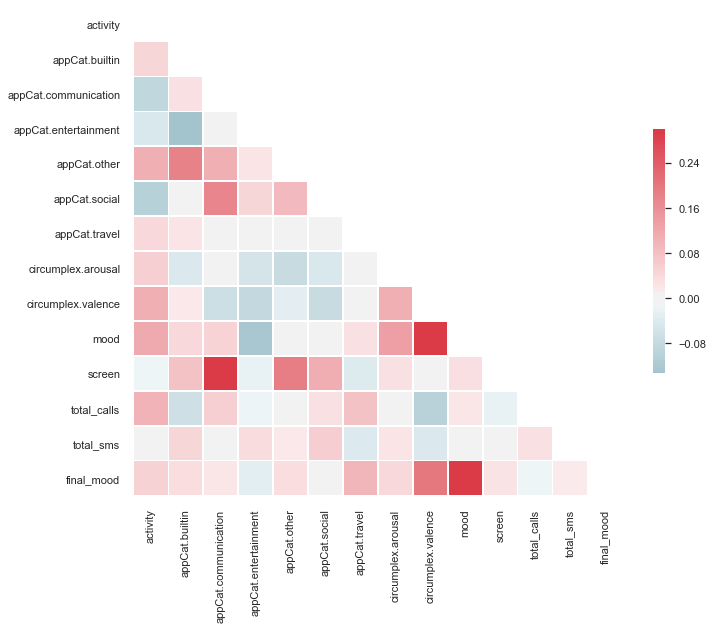

In [197]:
sns.set(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = df_agg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.figure.savefig("figures/correlation_heatmap.png")

## Train Models

In [248]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler  # scale time features
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor

In [249]:
clf = Pipeline([
                ('scale', StandardScaler()),
                ('clf', GradientBoostingRegressor())
            ])

In [176]:
#y

In [170]:
#np.isnan(y).any()
np.any(np.isnan(y))

False

In [261]:
# large folds -> to ensure enough training & validation data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from yellowbrick.model_selection import RFECV
import pickle
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel



SEED = 26062019

X = df_agg[df_agg.columns[2:-1]]
X = X.fillna(0)

y = df_agg[df_agg.columns[-1]]

#enc = preprocessing.LabelEncoder()
#y = enc.fit_transform(y)  #['HER2+', 'HR+', 'Triple Neg']


#enc = preprocessing.LabelEncoder()
#y = enc.fit_transform(y)

#C_range = 10.**np.arange(-5, 1)
#penalty_options = ['l1', 'l2']

#pipe = make_pipeline(RFECV(estimator=svc, cv=StratifiedKFold(y, 3), scoring='f1'), SVC())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

sfm = SelectFromModel(LassoCV(cv=10))
sfm.fit(X_train,y_train)
#X = feat.fit_transform(X, y)
print('Before Feature Selection: ', len(X_train.columns))
X_train = sfm.transform(X_train) #.shape[1]
print('After Feature Selection: ', len(X_train[0]))
#print(len(X_train[n_features]))
#print(èlgeok)
## later omringen met kfold_outer
old_er = 100
param = 0
best_model = ''

estimator_list = []
estimator = clf
param_grid =  {
        'clf__loss': ['ls', 'lad', 'huber', 'quantile'],
        'clf__n_estimators': [100,200, 300], # 0.01, 0.01, 0.1,
        'clf__learning_rate': [0.1, 0.01, 0.001, 0.0001]
    }
kfold_outer = KFold(n_splits=3,shuffle=True,random_state=SEED)
for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):
    # reset
    #print(train)

    #kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)

    X_tr, y_tr, X_valid, y_valid = X_train[train], y_train.iloc[train], X_train[valid], y_train.iloc[valid]
    #print(y_tr)
    grid = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error')
    #print(X_tr)

    grid.fit(X_tr, y_tr)  # contains nan
    y_pred = grid.predict(X_valid)
    #f1 = f1_score(y_valid, y_pred, average='micro')
    
    er = mean_squared_error(y_valid, y_pred)
    print('MSE:', str(er), 'Best params:', str(grid.best_params_))  # print best hyperparam
    #print(classification_report(y_valid, y_pred, target_names=['1', '2', '3']))
    #estimator_list.append(grid)
    if er < old_er:
        print('New Best')
        #print('Final F1:', str(er), 'Best params:', str(grid.best_params_))
        #eclf1 = EnsembleVoteClassifier(clfs=estimator_list, voting='hard', refit=False)
        print('R2-squared: ', grid.score(X_valid, y_valid))
        pickle.dump(grid, open('models/classical_model.sav', 'wb'))
        old_er = er
        param = grid.best_params_
        best_model = 'SVC'
        
print('Best model:', best_model, ' MSE:', old_er, 'Param:', param)    

Before Feature Selection:  13
After Feature Selection:  8
MSE: 0.5544821926999804 Best params: {'clf__learning_rate': 0.01, 'clf__loss': 'ls', 'clf__n_estimators': 200}
New Best
R2-squared:  -0.5544821926999804


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE: 0.4440074051942543 Best params: {'clf__learning_rate': 0.01, 'clf__loss': 'huber', 'clf__n_estimators': 100}
New Best
R2-squared:  -0.4440074051942543
MSE: 0.5517454058527019 Best params: {'clf__learning_rate': 0.01, 'clf__loss': 'ls', 'clf__n_estimators': 100}
Best model: SVC  MSE: 0.4440074051942543 Param: {'clf__learning_rate': 0.01, 'clf__loss': 'huber', 'clf__n_estimators': 100}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


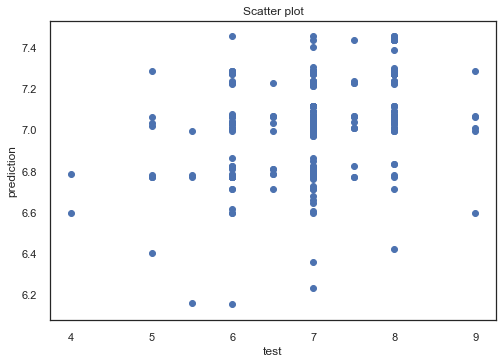

[[1.         0.34357732]
 [0.34357732 1.        ]]


In [262]:
# Plot
plt.scatter(y_valid, y_pred) # 
plt.title('Scatter plot')
plt.xlabel('test')
plt.ylabel('prediction')
plt.show()
print(np.corrcoef(y_valid, y_pred))

In [263]:
print('Before Feature Selection: ', len(X_test.columns))
X_test_t = sfm.transform(X_test) #.shape[1]
print('After Feature Selection: ', len(X_test_t[0]))
y_pred =  grid.predict(X_test_t)
err = mean_squared_error(y_test, y_pred)
print('MSE final:', str(err), 'Best params:', str(grid.best_params_))  # print best hyperparam
#print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))

Before Feature Selection:  13
After Feature Selection:  8
MSE final: 0.5433327775370523 Best params: {'clf__learning_rate': 0.01, 'clf__loss': 'ls', 'clf__n_estimators': 100}


In [ ]:
#X_test[X_test.columns[sfm.get_support()]]

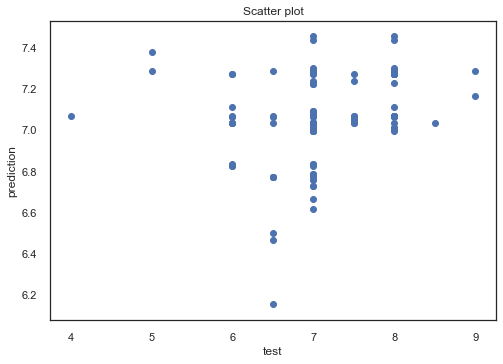

[[1.         0.26075588]
 [0.26075588 1.        ]]


In [264]:
# Plot
plt.scatter(y_test, y_pred) # 
plt.title('Scatter plot')
plt.xlabel('test')
plt.ylabel('prediction')
plt.show()
print(np.corrcoef(y_test, y_pred))